# Monte Carlo simulation of failure probability in mechanical design

<img src="https://risk-engineering.org/static/img/logo-RE.png" width="100" alt="" style="float:right;margin:15px;">
This notebook is an element of the free [risk-engineering.org courseware](https://risk-engineering.org/). It can be distributed under the terms of the [Creative Commons Attribution-ShareAlike licence](https://creativecommons.org/licenses/by-sa/4.0/).

Author: Eric Marsden <eric.marsden@risk-engineering.org>

---

This notebook contains an introduction to use of Python and the NumPy library for Monte Carlo simulation applied to a simple mechanical strength estimation, used for estimating failure probability. The [associated lecture slides](https://risk-engineering.org/monte-carlo-methods/) provide an introduction to the use of stochastic simulation methods.

In [1]:
import numpy
import scipy.stats
import pandas
import seaborn as sns
import matplotlib.pyplot as plt

## Problem statement

The hoop strength, or circumferential stress, to which a cylindrical vessel is exposed is given by the following equation:

$$\phi_H = \frac{P \cdot r}{W}$$

where $P$ is the internal pressure in the vessel (a gauge pressure, expressed in MPa), $r$ is the inside radius of the pipe, expressed in mm and $W$ is wall thickness, expressed in mm. $\phi_H$ is expressed in MPa (million Pascals). 

(This equation is only valid for “thin-walled” vessels, where $r$ is much larger than $t$.)

Pressure vessels and piping in petrochemical plants, and airplanes whose cabins are pressurized, can be thought of as thin-walled cylindrical vessels which must resist a certain level of internal pressure. Mechanical engineers will calculate the wall thickness required to resist a given internal pressure, then will take a safety factor into account.

This type of analysis is a part of [stress-strain analysis](https://en.wikipedia.org/wiki/Stress%E2%80%93strain_analysis) in mechanical or civil engineering. This is used during system design to check that a structure is safe (that the strain on every component remains lower than the stress to which it will be exposed, plus a certain safety margin) and to optimize the use of materials (reduce the amount of materials used while remaining within the safety margin). 

We will make the following assumptions concerning the distribution of our input variables:

- pipe radius $r$ follows a normal distribution with a mean of 60 mm and CV of 0.05 (5%)

- wall thickness $W$ follows a normal distribution with a mean of 4 mm and CV of 0.05

- the yield strength is also a random variable, following a normal distribution with a mean of 200 MPa and CV of 0.1 (yield strength is a property of a material; it’s the level of stress at which the material start to deform plastically, or fail from a mechanical point of view)

- internal pressure in the vessel is assumed to be constant at 10 MPa

We want to use a Monte Carlo simulation to estimate the probability of failure, which arises when the stress exceeds the yield strength of the vessel.

Start by defining functions that generate simulated values for the stress and for the yield strength of the vessel.

In [2]:
def calculate_stress():
    P = 10
    # note that the stdev is the mean times the coefficient of variation CV
    radius = scipy.stats.norm(60, 60*0.05).rvs()
    W = scipy.stats.norm(4, 4*0.05).rvs()
    return P * radius / W

def calculate_yield_strength():
    return scipy.stats.norm(200, 200*0.1).rvs()

Let’s run a Monte Carlo simulation to see how many times the stress exceeds the yield strength of the vessel, given our assumptions.

In [3]:
N = 1000
failures = 0
stresses = numpy.empty(N)
yield_strengths = numpy.empty(N)
for i in range(N):
    stresses[i] = calculate_stress()
    yield_strengths[i] = calculate_yield_strength()
    if stresses[i] > yield_strengths[i]:
        failures += 1

We can examine the probability distributions of the stress and the yield strength.

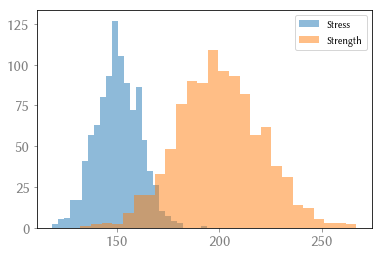

In [4]:
plt.hist(stresses, alpha=0.5, label="Stress")
plt.hist(yield_strengths, alpha=0.5, label="Strength")
plt.legend(loc='upper right');

Note that the points where failure occurs are the intersection between the two histograms. We can estimate the probability of this failure thanks to the simulation we ran above.

In [5]:
# the probability of failure
failures / float(N)

0.018

## Aside on vectorization

Our code above uses for loops to run the simulation, which, in most programming languages, is the standard way of executing the same calculation a large number of times. However, the NumPy library offers the possibility of executing vector or matrix arithmetic, in which the same operation is executed on all matrix elements “simultaneously”. This allows you to write less verbose code which often executes more quickly on modern computers. For example:

In [6]:
N = 10
ones = numpy.ones(N)
numpy.sqrt(ones + 3 * ones)

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

On our hoop strength example, we could have written more compactly:

In [7]:
N = 10000
P = 10
radius = scipy.stats.norm(60, 60*0.05).rvs(N)
W = scipy.stats.norm(4, 4*0.05).rvs(N)
yield_strength = scipy.stats.norm(200, 200*0.1).rvs(N)
# sum() adds the items in the vector which are not False
((P * radius / W) > yield_strength).sum() / float(N)

0.0148